<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/UN_decade_banner.png' align='right' width='100%'/>

<a href="../../../../Index.ipynb"><< Index</a>

## General principle of computing one point of the global MSL ##

The global Mean Sea Level is computed from the altimetric "reference mission", namely today (2023/04/19), Sentinel-6 Michael Freilich.
We won't compute the whole time series here, but show the basis of computing one point in this along-time data series.

<br>made for Eumetsat Copernicus Marine Data Service by V. Rosmorduc, CLS

** Import libraries **

In [21]:
import glob                            # a package that helps with file searching
import os                              # a library that allows us access to basic operating system commands
import eumdac                          # a tool that helps us download via the eumetsat/data-store
import json                            # a library that helps us make JSON format files
import datetime                        # a library that allows us to work with dates and times
import shutil                          # a library that allows us access to basic operating system commands like copy
import cartopy                         # a library that supports mapping and projection
import cartopy.crs as ccrs
import matplotlib                      # a library the provides plotting capability
import matplotlib.pyplot as plt        # a library the provides plotting capability
import xarray as xr                    # a library that helps us work efficiently with multi-dimensional arrays
import numpy as np                     # a library that lets us work with arrays; we import this with a new name "np"
from scipy import stats                # a statistical library
import warnings                        # a library that supports managing warning messages

#we will look at the plot within the notebooks
%matplotlib inline

In [7]:
# Create a download directory for our products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

download_data = True

cycle = 53

In [8]:
if download_data:
# load credentials
    with open(os.path.join(os.path.expanduser("~"),'.eumdac_credentials')) as json_file:
        credentials = json.load(json_file)
        token = eumdac.AccessToken((credentials['consumer_key'], credentials['consumer_secret']))
        print(f"This token '{token}' expires {token.expiration}")

# create data store object
    datastore = eumdac.DataStore(token)

This token 'dff0ff08-f02f-330a-bffd-2fe2245aa123' expires 2024-03-19 12:24:36.044501


In [9]:
if download_data:
    #list Poseidon-4 collection IDs
    datastore = eumdac.DataStore(token)
    for collection_id in datastore.collections:
        if ("Poseidon-4" in collection_id.title):
            print(f"Collection ID({collection_id}): {collection_id.title}")

Collection ID(EO:EUM:DAT:0237): Poseidon-4 Altimetry Level 1B Low Resolution (baseline version F06) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0855): Poseidon-4 Altimetry Level 2 High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0857): Poseidon-4 Altimetry Level 2P Low Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0239): Poseidon-4 Altimetry Level 2 Low Resolution (baseline version F06) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0851): Poseidon-4 Altimetry Level 1B High Resolution - Sentinel-6
Collection ID(EO:EUM:DAT:0143): Poseidon-4 Level 3 Wind/Wave Products Low Resolution in NRT - Sentinel-6
Collection ID(EO:EUM:DAT:0236): Poseidon-4 Altimetry Level 1A High Resolution (baseline version F06) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0839): Poseidon-4 Altimetry Level 1B High Resolution (baseline version F08) - Sentinel-6 - Reprocessed
Collection ID(EO:EUM:DAT:0841): Poseidon-4 Altimetry Level 2 High Resolution (baseline version F08) - Sentinel-6 - 

From the lists above, we will pick the "Poseidon-4 Altimetry Level 2 Low Resolution (baseline version FXX) - Sentinel-6 - Reprocessed" collection ID. (the baseline number is evolving with new reprocessing; if you have older files from another baseline (see at the end of the folder/file name, just before the .SEN6 or .nc), replace them with the newest, *_do not use inhomogeneous baselines_* especially not in computations such as mean sea level)

To download only the files we'll be using, select only the "reduced" (RED) files only from the NTC delay ('NT') and download it. (NB using the Reprocessed product, they will always be "NTC", so there is no necessity for this condition in fact - just to show how it is done)

In [10]:
if download_data:
    collectionID = 'EO:EUM:DAT:0842'
    # space/time filter the collection for products
    selected_collection = datastore.get_collection(collectionID)

    products = selected_collection.search(
        cycle=cycle,
        timeliness="NT")

    print(f"Found {len(products)} products")

Found 254 products


In [11]:
if download_data:
    for product in products:
        for entry in product.entries:
            if 'S6A_P4_2__LR_RED_' in entry:
                with product.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), 'products',fsrc.name), mode='wb') as fdst:
                    print(f'Downloading {fsrc.name}.')
                    shutil.copyfileobj(fsrc, fdst)
                    print(f'Download of file {fsrc.name} finished.')


Download of file S6A_P4_2__LR_RED__NT_053_254_20220427T035656_20220427T045309_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_053_253_20220427T030043_20220427T035656_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_053_252_20220427T020430_20220427T030043_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_053_251_20220427T010817_20220427T020430_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_053_250_20220427T001204_20220427T010817_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_053_249_20220426T231552_20220427T001204_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_053_248_20220426T221939_20220426T231552_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_053_247_20220426T212326_20220426T221939_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_053_246_20220426T202713_20220426T212326_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_053_245_20220426T193100_20220426T202713_F08.nc finished.
Download of file S6A_P4_2__LR_RED__NT_053_244_2022

We read the data from a full cycle (track 1 to 254) from Sentinel-6 Reduced Non Time Critical level 2 Low resolution data.   
LR are more homogeneous with previous mission (and you don't need high resolution to compute a global mean sea level). 
NTC are more accurate (in particular relative to the orbit), and more homogeneous along the mission; when a reprocessing is done, it is done on the whole mission from its beginning, while NRT or STC processing or corrections can be changed without this applied to the oldest data. 
Reduced is because we don't need the extra information you have in the standard version.

reading all the files together + defining needed variables

In [22]:
s6_files = glob.glob(os.path.join(download_dir,'S6A_P4_2__LR_RED_*.nc'))
#we sort the files - by default it is "alphabetical" order, but pass numbers are also correctly ordered, which is our goal
# this sorting will provide with a well-orderer dataset/nc file (see next cell). 
# It is not absolutely vital to the present computation, but could be necessary in other cases
s6_files.sort()

if s6_files != []:
    s6cycle01 = xarray.open_mfdataset(s6_files, group='data_01', combine='nested', concat_dim='time', compat='no_conflicts')
    s6cycle01ku = xarray.open_mfdataset(s6_files, group='data_01/ku', combine='nested', concat_dim='time', compat='no_conflicts')
else:
    print('no files found')

#definition of the variables we will need
lat = s6cycle01['latitude']
lon = s6cycle01['longitude']
time = s6cycle01['time']
ssha = s6cycle01ku['ssha']

# use of the different flags ; 0 is for ocean (surface flag), no rain nor sea ice or for "good" (quality flags)
# alternate values are > 0, so if all the conditions are met, the sum will be zero.
flags_ssha = np.array(s6cycle01.surface_classification_flag) \
           + np.array(s6cycle01ku.range_ocean_qual) \
           + np.array(s6cycle01ku.off_nadir_angle_wf_ocean_qual) \
           + np.array(s6cycle01ku.sig0_ocean_qual) \
           + np.array(s6cycle01ku.swh_ocean_qual) \
           + np.array(s6cycle01.rain_flag) \
           + np.array(s6cycle01.meteo_map_availability_flag) \
           + np.array(s6cycle01.mean_sea_surface_sol1_qual) \
           + np.array(s6cycle01.rad_sea_ice_flag) \
           + np.array(s6cycle01.rad_wet_tropo_cor_qual)
ssha[flags_ssha != 0.0] = np.nan

# remove a few extreme outliers left
ssha = ssha.where((ssha > -2) & (ssha < 2))


In [23]:
s6cycle01

<xarray.Dataset> Size: 363MB
Dimensions:                                   (time: 849249)
Coordinates:
    latitude                                  (time) float64 7MB dask.array<chunksize=(3373,), meta=np.ndarray>
    longitude                                 (time) float64 7MB dask.array<chunksize=(3373,), meta=np.ndarray>
  * time                                      (time) datetime64[ns] 7MB 2022-...
Data variables: (12/88)
    altitude                                  (time) float64 7MB dask.array<chunksize=(3373,), meta=np.ndarray>
    altitude_rate                             (time) float64 7MB dask.array<chunksize=(3373,), meta=np.ndarray>
    altitude_rate_mean_sea_surface            (time) float64 7MB dask.array<chunksize=(3373,), meta=np.ndarray>
    angle_of_approach_to_coast                (time) float32 3MB dask.array<chunksize=(3373,), meta=np.ndarray>
    climato_use_flag                          (time) float32 3MB dask.array<chunksize=(3373,), meta=np.ndarray>
    dac                                       (time) float32 3MB dask.array<chunksize=(3373,), meta=np.ndarray>
    ...                                        ...
    total_electron_content                    (time) float32 3MB dask.array<chunksize=(3373,), meta=np.ndarray>
    wind_speed_alt                            (time) float32 3MB dask.array<chunksize=(3373,), meta=np.ndarray>
    wind_speed_alt_mle3                       (time) float32 3MB dask.array<chunksize=(3373,), meta=np.ndarray>
    wind_speed_alt_nr                         (time) float32 3MB dask.array<chunksize=(3373,), meta=np.ndarray>
    wind_speed_mod_u                          (time) float32 3MB dask.array<chunksize=(3373,), meta=np.ndarray>
    wind_speed_mod_v                          (time) float32 3MB dask.array<chunksize=(3373,), meta=np.ndarray>

Plotting the full cycle ; at this stage, we have along-track data with time as dimension. 
Note that this plot is taking time with 254 times about 3350 points to plot (**_this cell can be skipped with no impact on the following computations_**)

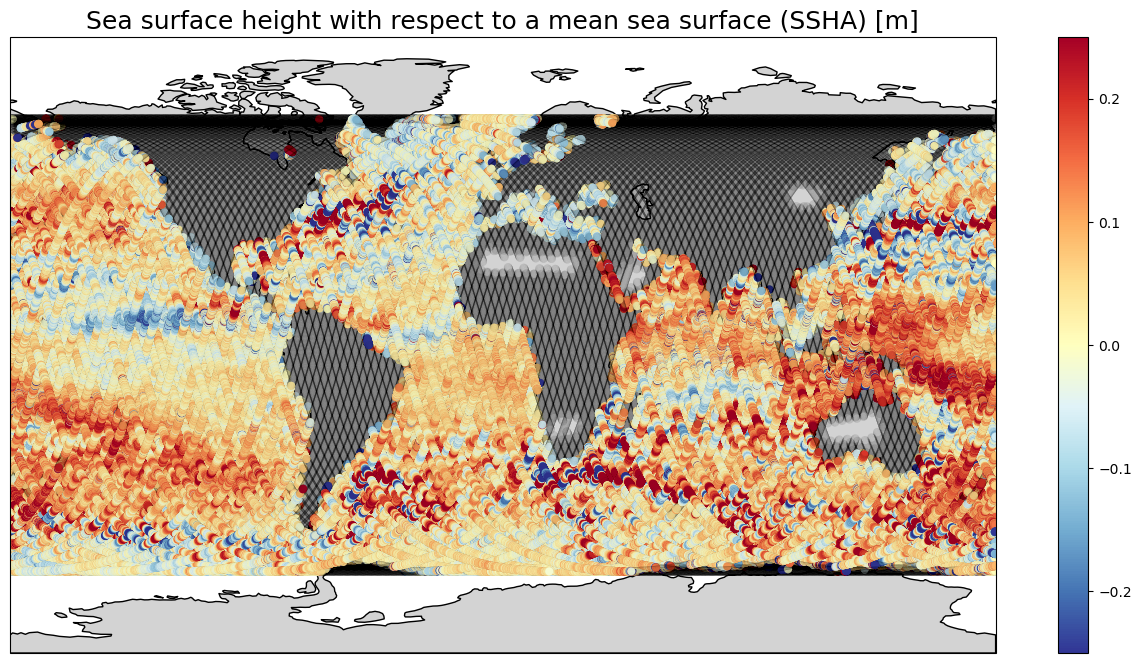

In [25]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
#zoom on the Mediterranean Western basin
#ax.set_extent([0, 25, 30, 50], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
# actually plot the data
tracks = ax.scatter(lon, lat, c=ssha, cmap='RdYlBu_r', marker='o',  vmin=-0.25, vmax=0.25, edgecolors='black', linewidth=0.01)
cbar = plt.colorbar(tracks)
plt.title('Sea surface height with respect to a mean sea surface (SSHA) [m]', size=18)
plt.show()

We combine the datasets from the two groups in one, extracting only ssha (which is in the Ku group), and the coordinates/dimension (which are in the group above). We define the attributes which can be needed for an output NetCDF, so as to be able to use it as such afterwards (not necessary if you only want to compute the mean of the cycle).

In [26]:
#creating a proper dataset with useful attributes for a nc files 
ds = xarray.Dataset(
    {'ssha01': (['time'],  \
                ssha.data, \
                {'standard_name' : 'sea_surface_height_above_sea_level', \
                 'units' : "m", \
                 'coordinates' : "longitude latitude"})}, 
    coords={
        'time': (['time'], \
                 time.data, \
                 {'standard_name' : 'time', \
                  #'units' : "seconds since 2000-01-01 00:00:00.0", \ # a unit is kept in the concatenation by this dimension
                  'coordinates' : "longitude latitude"}),
        'lon01': (['time'], lon.data, \
                {'standard_name' : 'longitude', \
                 'units' : "degrees_east", \
                 'coordinates' : "longitude latitude"}), 
        'lat01': (['time'], lat.data, \
                  {'standard_name' : 'latitude', \
                   'units' : "degrees_north", \
                   'coordinates' : "longitude latitude"})})

# a few time steps are duplicated at the end of some passes and at the beggining of the following one. We are removing them.
## solution with an xarray version > 2022, to be tested 
#ds = ds.drop_duplicates(dim="time",  keep='first')
# solution with xarray versions before 2022: selection only non (~) duplicated times
ds = ds.sel(time=~ds.indexes['time'].duplicated())

ds.to_netcdf('sshafullcycle_'+str(cycle)+'.nc')
s6cycle01.close()
s6cycle01ku.close()
ds

<xarray.Dataset> Size: 27MB
Dimensions:  (time: 849234)
Coordinates:
  * time     (time) datetime64[ns] 7MB 2022-04-17T06:54:38 ... 2022-04-27T04:...
    lon01    (time) float64 7MB dask.array<chunksize=(3373,), meta=np.ndarray>
    lat01    (time) float64 7MB dask.array<chunksize=(3373,), meta=np.ndarray>
Data variables:
    ssha01   (time) float64 7MB dask.array<chunksize=(3373,), meta=np.ndarray>

Now we are "binning" the data in the two spatial dimensions, i.e. averaging them over boxes in longitude/latitude ; we do not take into account values at NaN (any arithmetic operation with a NaN in will result in NaN: we want to ignore those values when they are only part of the pixel - not when a pixel is always at NaN). However, note that due to the size of the pixels we are defining, a lot of pixels will be in part over lands. 

In [27]:
# steps in degrees for the pixels we will create. 
# do not go much under those values, due to the gap between tracks in longitude (315 km at the Equator)
steplon = 3
steplat = 1
lat_min = -90. 
lon_min = 0.
lat_max = 90; lon_max = 360 

#creating the arrays of longitudes and latitudes
# NB. last point is not within the array in Python.
binnedlon = np.arange(lon_min,lon_max+steplon,steplon)
binnedlat = np.arange(lat_min,lat_max+steplat,steplat)
test = stats.binned_statistic_2d(ds.lon01, ds.lat01, ds.ssha01, statistic=np.nanmean,  bins=[binnedlon,binnedlat])


The binned_statistic-2d is outputing a (x,y) ndarray. However, in particular to plot the data on a map, you'll need a (lat,lon) matrix, so you have to "transpose" your ndarray (i.e. to switch dimensions).

Moreover, not to miss the 0 - 360 transition, we added one point to the statistics. 
We are choosing to reference the pixels ("registration") at their center ("pixel registration"), so we shift by half a pixel the lon/lat defining each pixel. The other usual solution is top left ("gridline registration").

In [28]:
#defining an output xarray dataset
binnedgrid = xarray.Dataset({
    'binnedssha': xarray.DataArray(
        data = test.statistic.T,
        dims = ['latitude','longitude'],
        coords =  {'latitude': test.y_edge[:-1]+ steplat/2, 'longitude': test.x_edge[:-1] + steplon/2},
        attrs = {'long_name': 'sea surface heights anomalies by lat/lon bins', 'units': 'm', 'standard_name': 'sea_surface_height_above_sea_level'}
        )
    },
    #global attributes can be added
    attrs = { }
    )
binnedgrid

<xarray.Dataset> Size: 175kB
Dimensions:     (latitude: 180, longitude: 120)
Coordinates:
  * latitude    (latitude) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * longitude   (longitude) float64 960B 1.5 4.5 7.5 10.5 ... 352.5 355.5 358.5
Data variables:
    binnedssha  (latitude, longitude) float64 173kB nan nan nan ... nan nan nan

In [29]:
# saving the output binned grid in a netCDF file
binnedgrid.to_netcdf('binnedgrid.nc')

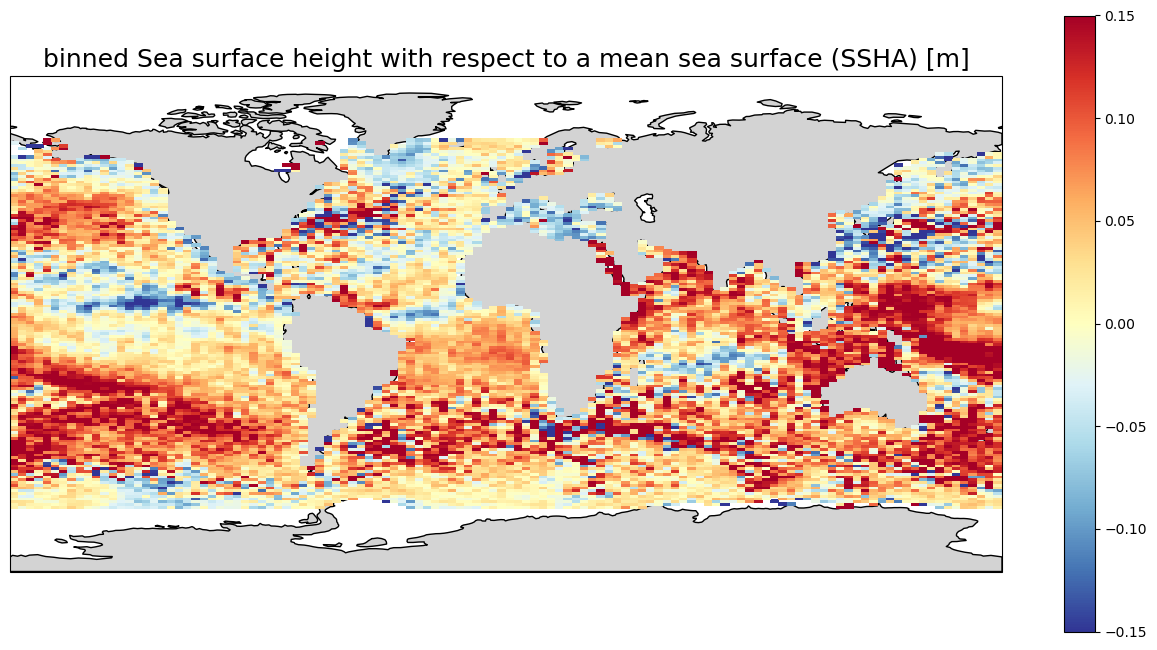

In [30]:
# plotting the resulting grid. It is a very pixellized map - which was the objective.

plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
# overlaying the continents on top makes a nicer plot (zorder continent > zorder SSHA).
# ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k')
ax.set_extent([-180, 180, lat_min, lat_max])
mymap = ax.pcolor(binnedgrid.longitude, binnedgrid.latitude, binnedgrid.binnedssha, cmap='RdYlBu_r', vmin=-0.15, vmax=0.15, shading=None, zorder=0)
# Add a colorbar to the map object to give scale
plt.colorbar(mymap, ax=ax)
# Add a title to the map object
plt.title('binned Sea surface height with respect to a mean sea surface (SSHA) [m]', size=18)
plt.show()                  

Computing the global mean for the cycle. The area of each pixel is different depending on the latitude, 
so we weight our pixels with cos(latitude) so as not to overestimate the high latitude contributions.

One more refinement would be to weight each binned pixel with the amount of ocean within (i.e. not count land in the whole pixel "weight"; here we overweight coastal areas in the computation).


In [31]:
weights = np.cos(np.deg2rad(binnedgrid['latitude']))
weights.name = "weights"
ssha_weighted = binnedgrid['binnedssha'].weighted(weights)
ssha_weighted
weighted_mean = ssha_weighted.mean(("longitude", "latitude"))
print("the Global mean sea level value (with respect to a 20-year mean) for this cycle is: ", np.around(weighted_mean.values,4), " meters")

the Global mean sea level value (with respect to a 20-year mean) for this cycle is:  0.0412  meters


This was an exercice to show how it is done. 

It is not, however, the whole processing to do to output a complete 30-year long time series showing sea level long-term changes and trend: once done on every single cycle (since Jan. 1993! - use harmonized data with homogeneous corrections and references). To have an interannual trend you need to remove seasonal cycles, filter for 60-day and six-month periodic variations. You also have intermission biases to apply when switching from one satellite to its follow-on. You can also (or not) remove a bias to take the Glacial Isostatic Adjustement into account (-0.3 mm/yr). See https://www.aviso.altimetry.fr/en/data/products/ocean-indicators-products/mean-sea-level/processing-and-corrections.html for the details of the complete computation of a mean sea level time series from the reference mission.

Beware that the zero level of this computation is *_not_* the one you can usually see on altimetry-derived mean sea level curves : here zero is set by construction at the 20-year mean, while most usually the zero is set at the level of the beginning of the series (in 1993).

<hr>
<a href="../../../../Index.ipynb"><< Index</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/applications/ocean-case-studies">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>